In [1]:
from cartopy import geodesic as geo
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from scipy.optimize import bisect, minimize_scalar
import shapely

# geoid calculator
geoid = geo.Geodesic()

# See debug plots
debug_plots = False

# Solution for Blog Post 2020-12-01
Original post [is here](https://www.aerosci.dev/2020/12/01/left-right-side-of-line.html).

## Determining Which Side of a Geodesic a Point is On

Let there be a point on the continent of North America: lat=38, lon=-80 (deg).

In [2]:
point_off_line_deg = (-82, 38) # (lon, lat)

In [3]:
# define an arbitrary line on the ellipsoid
start_point_deg = (-79.0, 37.5)
geodesic_length_m = 250.0 * 1852.0

In [4]:
course_deg = 335
b = geoid.direct(start_point_deg, course_deg, geodesic_length_m)
end_point_deg = np.array(b)
end_point_deg = (end_point_deg[0][0], end_point_deg[0][1])
# print(end_point_deg)

In [5]:
if debug_plots:
    fig_debug = go.Figure([
         go.Scattergeo(lat=[point_off_line_deg[1]], 
                       lon=[point_off_line_deg[0]], 
                       name='point_off_line'),
         go.Scattergeo(lat=[start_point_deg[1]], 
                       lon=[start_point_deg[0]], 
                       marker=dict(color='black'),
                       name='start_point'),
         go.Scattergeo(lat=[end_point_deg[1]], 
                       lon=[end_point_deg[0]], 
                       marker=dict(color='magenta'),
                       name='end_point'),
         go.Scattergeo(lat=[start_point_deg[1], end_point_deg[1]], 
                       lon=[start_point_deg[0], end_point_deg[0]], 
                       mode='lines',
                       name='line_on_ellipsoid'),
    ])
    fig_debug.update_layout(geo=dict(scope='north america'))


In [13]:
distance_from_start_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, start_point_deg))[0][0]
distance_from_end_point_to_point_off_line_m = np.array(geoid.inverse(point_off_line_deg, end_point_deg))[0][0]
y_intercept_shift = distance_from_start_point_to_point_off_line_m + (distance_from_end_point_to_point_off_line_m-distance_from_start_point_to_point_off_line_m)/2

def distance_from_point_off_line(distance_from_start_point_m=0):
    b = geoid.direct(start_point_deg, course_deg, distance_from_start_point_m)
    point_on_line_at_distance_deg = np.array(b)[0]
    c = geoid.inverse(point_off_line_deg, (point_on_line_at_distance_deg[0], point_on_line_at_distance_deg[1]))
    distance_from_point_off_line_m = np.array(c)[0][0]
    
    if debug_plots:
        fig_debug.add_trace(
            go.Scattergeo(lat=[point_on_line_at_distance_deg[1]], 
                       lon=[point_on_line_at_distance_deg[0]], 
                       mode='markers',
                       hovertext=f'y:{distance_from_point_off_line_m}',
                       name=f'x:{distance_from_start_point_m}')
        )
    
    return distance_from_point_off_line_m

def find_closest_point_on_line():
    # use bisection to find the closest point along the geodesic within a tolerance of 1 meters
    result = minimize_scalar(fun=distance_from_point_off_line, bounds=(0, geodesic_length_m), method='bounded', options={'xatol': 10, 'maxiter': 500, 'disp': 0})
    if not result.success:
        print(f'FAIL: {result.message}')
    distance_from_start_m = result.x
    
    # Calculate the lat/lon of this point
    b = geoid.direct(start_point_deg, course_deg, distance_from_start_m)
    perpendicular_point_on_line_deg = (np.array(b)[0][0], np.array(b)[0][1])
    return perpendicular_point_on_line_deg

In [14]:
closest_point_on_line_deg = find_closest_point_on_line()
print(closest_point_on_line_deg)

if debug_plots:
    fig_debug.show()

(-79.80573313164255, 38.8487357391888)


Let's visualize this!

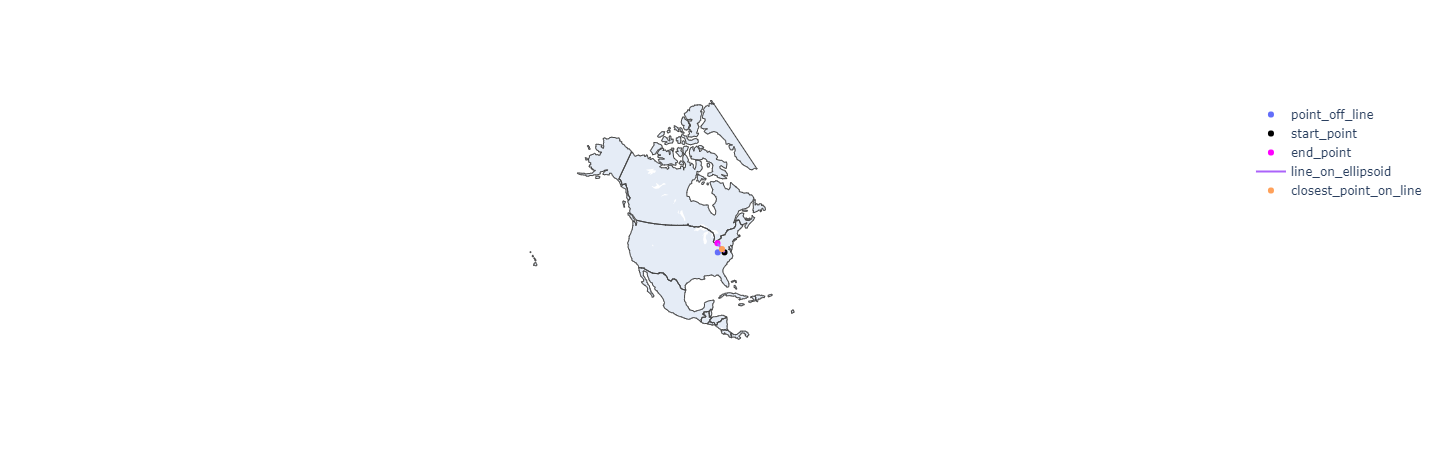

In [15]:
fig = go.Figure([
     go.Scattergeo(lat=[point_off_line_deg[1]], 
                   lon=[point_off_line_deg[0]], 
                   name='point_off_line'),
     go.Scattergeo(lat=[start_point_deg[1]], 
                   lon=[start_point_deg[0]], 
                   marker=dict(color='black'),
                   name='start_point'),
     go.Scattergeo(lat=[end_point_deg[1]], 
                   lon=[end_point_deg[0]], 
                   marker=dict(color='magenta'),
                   name='end_point'),
     go.Scattergeo(lat=[start_point_deg[1], end_point_deg[1]], 
                   lon=[start_point_deg[0], end_point_deg[0]], 
                   mode='lines',
                   name='line_on_ellipsoid'),
     go.Scattergeo(lat=[closest_point_on_line_deg[1]], 
                   lon=[closest_point_on_line_deg[0]], 
                   name='closest_point_on_line'),
])
fig.update_layout(geo=dict(scope='north america'))
fig.show()

The figure above shows a line starting at `start_point` and ending at `end_point`. The point `point_off_line` is clearly to the LEFT of the line according to the implied directionality of the line. And, the point on the line that is nearest `point_off_line` is `closest_point_on_line`. 

So, how do we algorithmically find that `point_off_line` is to the LEFT?

Using vector calculus!

In [9]:
def side_of_line(geodesic=None, lat_lon_point:tuple=None):
    return

## Test Stuff

In [10]:
import pyproj
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
x, y, z = pyproj.transform(lla, ecef, point_off_line_deg[1], point_off_line_deg[0], 0, radians=False)
print(f'{x}, {y}, {z}')

701796.9898499511, 548303.9008954476, -6294478.015756379


/home/sbowman/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1



In [11]:
print(pyproj.__version__)

2.6.1.post1


In [12]:
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:4326", "epsg:3857")
transformer.transform(12, 12)

(1335833.8895192828, 1345708.4084091093)